In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import gc

2.6.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus
tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*5)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
img_array = cv2.imread("images/train/angry/Training_31410334.jpg")

In [4]:
img_array.shape

(48, 48, 3)

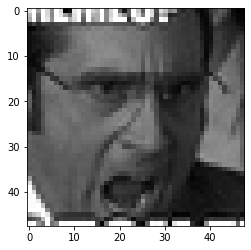

In [5]:
plt.imshow(img_array)

In [6]:
data_directory = "images/train"

In [7]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
images_per_classe = 50

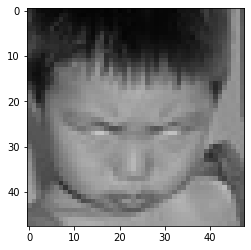

In [8]:
for category in classes:
    path = os.path.join(data_directory, category)
    for img in os.listdir(path)[0:images_per_classe]:
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

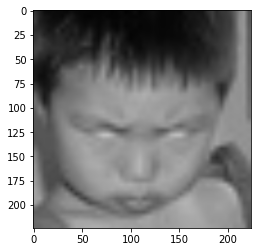

In [9]:
img_size = 224 #ImageNet => 224 x 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
new_array.shape

(224, 224, 3)

# Read all the images and convert them in to array

In [11]:
training_data = [] ## data

def create_training_data():
    for category in classes:
        path = os.path.join(data_directory, category)
        class_num = classes.index(category)
        for img in os.listdir(path)[0:images_per_classe]:
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [12]:
create_training_data()

In [13]:
print(len(training_data))

350


In [14]:
import random

random.shuffle(training_data)

In [15]:
x = [] ## data / feature
y = [] ## label

for features, label in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x, dtype='uint8').reshape(-1, img_size, img_size,3) ## converting it to 4 dimension

In [16]:
x.shape

(350, 224, 224, 3)

In [17]:
del training_data
gc.collect()

6184

In [18]:
# normalize the data
x = x / 255.0

In [19]:
y = np.array(y)

In [20]:
y.shape

(350,)

# Deep learning model for training - transfer learning

In [21]:
model = tf.keras.applications.MobileNetV2() ## Pre - trained Model

In [22]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#  Transfer learning - Turning, weights will start from last check point

In [23]:
base_input = model.layers[0].input

In [24]:
base_output = model.layers[-2].output

In [25]:
final_output = layers.Dense(128)(base_output) ## adding new layer, after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) ## activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [26]:
new_model = tf.keras.Model(inputs = base_input, outputs=final_output)

In [27]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [28]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [29]:
new_model.fit(x, y, epochs = 5, batch_size=16)

Epoch 1/5


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/Conv1/Conv2D (defined at \AppData\Local\Temp\ipykernel_46888\2737498773.py:1) ]] [Op:__inference_train_function_9996]

Function call stack:
train_function
